# WebLINX

| [**🤗Dataset**](https://huggingface.co/datasets/McGill-NLP/WebLINX) | [**📄Paper**](https://arxiv.org/abs/2402.05930) | [**🌐Website**](https://mcgill-nlp.github.io/weblinx) |
| :--: | :--: | :--: |
| [**🤖Models**](https://huggingface.co/collections/McGill-NLP/weblinx-models-65c57d4afeeb282d1dcf8434) | [**💻Explorer**](https://huggingface.co/spaces/McGill-NLP/weblinx-explorer) | [**🐦Tweets**](https://twitter.com/sivareddyg/status/1755799365031965140) |


> **[WebLINX: Real-World Website Navigation with Multi-Turn Dialogue](https://mcgill-nlp.github.io/weblinx)**\
> _[Xing Han Lù*](https://xinghanlu.com), [Zdeněk Kasner*](https://kasnerz.github.io/), [Siva Reddy](https://sivareddy.in)_

## Quickstart

To get started, we will follow the quickstart instructions from the [WebLINX Huggingface Dataset](https://huggingface.co/datasets/McGill-NLP/WebLINX)

In [1]:
!pip install datasets huggingface_hub -q

In [ ]:
from datasets import load_dataset
from huggingface_hub import snapshot_download

# Load the validation split
valid = load_dataset("McGill-NLP/weblinx", split="validation")

# Download the input templates and use the LLaMA one
snapshot_download(
    "McGill-NLP/WebLINX", repo_type="dataset", allow_patterns="templates/*", local_dir="."
)
with open('templates/llama.txt') as f:
    template = f.read()

# To get the input text, simply pass a turn from the valid split to the template
turn = valid[0]
turn_text = template.format(**turn)

You can now use `turn_text` as an input to LLaMA-style models. For example, you can use Sheared-LLaMA:

In [ ]:
from transformers import pipeline

action_model = pipeline(
    model="McGill-NLP/Sheared-LLaMA-2.7B-weblinx", device=0, torch_dtype='auto'
)

In [4]:
out = action_model(turn_text, return_full_text=False, max_new_tokens=64, truncation=True)
pred = out[0]['generated_text'].strip()

print("Ref:", turn["action"])
print("Pred:", pred)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Ref: click(uid="67e2a5fb-8b1d-41a0")
Pred: click(uid="67e2a5fb-8b1d-41a0")


You can find all the models we finetuned on WebLINX in this [Hugginface Model Collection](https://huggingface.co/collections/McGill-NLP/weblinx-models-65c57d4afeeb282d1dcf8434).

## Using the WebLINX library

Now that we know how to access the dataset via Huggingface, let's take a look at the official [WebLINX Python library](https://github.com/mcGill-NLP/weblinx). We will follow instructions from the [library documentations](https://mcgill-nlp.github.io/weblinx/docs/).

In [5]:
# This part is only for Google Colab
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Install weblinx
!pip install weblinx -q

  Preparing metadata (setup.py) ... done


In [ ]:
from huggingface_hub import snapshot_download

demo_names = ['saabwsg', 'ygprzve', 'iqaazif']
patterns = [f"demonstrations/{name}/*" for name in demo_names]

# Download a subset of the dataset, or...
snapshot_download(
    repo_id="McGill-NLP/WebLINX-full", repo_type="dataset", local_dir="./wl_data", allow_patterns=patterns
)

In [7]:
!ls wl_data/demonstrations/saabwsg/

bboxes	form.json  metadata.json  pages  replay.json  screenshots  video.mp4


In practice, you might want to load a complete set, where you'd use something like this:
```
demo_names = wl.utils.load_demo_names_in_split(split_path, split='valid')
```

But we will keep using a sample subset of `demo_names` to keep things simple in this tutorial.

In [8]:
from pathlib import Path
from PIL import Image
import weblinx as wl

wl_dir = Path("./wl_data")
base_dir = wl_dir / "demonstrations"
split_path = wl_dir / "splits.json"

demos = [wl.Demonstration(name, base_dir=base_dir) for name in demo_names]

In [9]:
# Select a demo to work with
demo = demos[0]

# Load the Replay object, which contains the turns of the demonstration
replay = wl.Replay.from_demonstration(demo)

# Filter the turns to keep only the ones that are relevant for the task
turns = replay.filter_by_intents(
    "click", "textInput", "load", "say", "submit"
)

# Only keep the turns that have a good screenshot (i.e., the screenshot is not empty)
turns = wl.filter_turns(
    turns, lambda t: t.has_screenshot() and t.get_screenshot_status() == "good"
)

# Remove chat turns where the speaker is not the navigator (e.g. if you want to train a model to
# predict the next action)
turns = wl.filter_turns(
    turns,
    lambda turn: not (
        turn.type == "chat" and turn.get("speaker") != "navigator"
    ),
)

Let's see what it looks like:

In [10]:
turns[::2]

[Turn(index=5, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=8, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=12, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=16, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=26, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=31, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=37, demo_name=saabwsg, base_dir=wl_data/demonstrations),
 Turn(index=41, demo_name=saabwsg, base_dir=wl_data/demonstrations)]

The `Turn`, `Replay`, `Demonstration` objects are designed to help you access useful parts of the data without too much effort!

For example, the `Turn` object lets you access the HTML, bounding boxes, screenshot, etc.

HTML sneak peak: <head prefix="og: http://ogp.me/ns#" data-webtasks-id="0521e4b5-5f60-46c7">
Random Bounding Box: {'x': 0, 'y': 0, 'width': 1349, 'height': 657, 'top': 0, 'right': 1349, 'bottom': 657, 'left': 0}



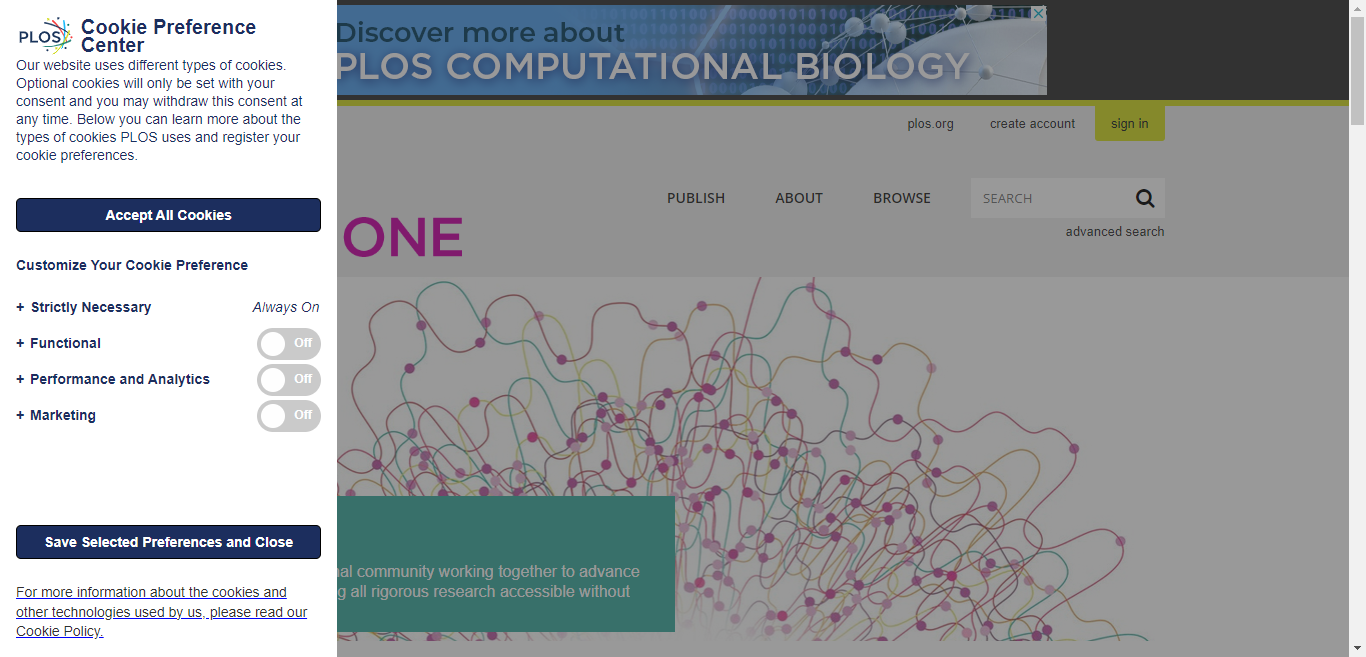

In [11]:
turn = turns[0]

print("HTML sneak peak:", turn.html[:75])
print("Random Bounding Box:", turn.bboxes['bc7dcf18-542d-48e6'])
print()

# We can even get the path to the screenshot and open with Pillow
Image.open(turn.get_screenshot_path())

The `Replay` object helps with working with turn-level manipulations (you can think of it as a list, and it is indexable and sliceable), whereas `wl.Demonstration` is designed to represent demonstrations at an abstract level.

In [12]:
print("Description:", demo.form['description'])
print("Does demo have replay.json?:", demo.has_file('replay.json'))
print("When was it uploaded?:", demo.get_upload_date())
print()
print("Number of turns in replay:", replay.num_turns)
print("All intents in replay:", replay.list_intents())
print("Some URLs in replay:", replay.list_urls()[1:3])

Description: Searched in Plos Biology recently published articles and provided summary
Does demo have replay.json?: True
When was it uploaded?: 2023-06-14 10:15:59

Number of turns in replay: 48
All intents in replay: ['paste', 'hover', 'copy', 'scroll', 'tabswitch', 'tabcreate', 'load', 'click', None]
Some URLs in replay: ['https://journals.plos.org/plosbiology/', 'https://journals.plos.org/plosbiology/search?filterJournals=PLoSBiology&filterStartDate=2023-05-15&filterEndDate=2023-06-14&q=&sortOrder=DATE_NEWEST_FIRST&utm_content=b&utm_campaign=ENG-467']


You can now use the turn as a Python object, allowing you complete freedom in how you want to process and use the data. If you are interested in how the core WebLINX API works, head over to the [documentation for the core `weblinx` module](https://mcgill-nlp.github.io/weblinx/docs/core/).